Neste projeto irei criar um modelo para identificação de risco de crédito, que é o risco do não pagamento por parte do tomador do crédito, ou o chamado risco de inadimplência.
O objetivo do modelo é treinar, testar e avaliar um modelo de machine learning capaz de prever com alto índice de acerto se uma operação de crédito resultará em inadimplência ou não.
Etapas do projeto:
-Exploração e limpeza dos dados;
-Feature engineering;
-Preparação dos dados;
-Seleção de um modelo de machine learning;
-Ajuste, treinamento, teste e avaliação do modelo selecionado.

Projeto inspirado por: https://medium.com/data-hackers/machine-learning-para-avalia%C3%A7%C3%A3o-de-risco-de-cr%C3%A9dito-49578b03b4b8

### Análise Exploratória e Limpeza dos Dados

In [ ]:
# Instalando o BaseMap 
!apt-get install libgeos-3.5.0 -qq
!apt-get install libgeos-dev -qq
!pip install https://github.com/matplotlib/basemap/archive/master.zip -q
!pip install pyproj==1.9.6 -q

E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

# Configurando o notebook
sns.set()
%matplotlib inline

# Lendo os dados
credito = pd.read_csv('http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0')
credito.head()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


In [ ]:
(credito.isnull().sum() / credito.shape[0] * 100).sort_values(ascending=False)

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


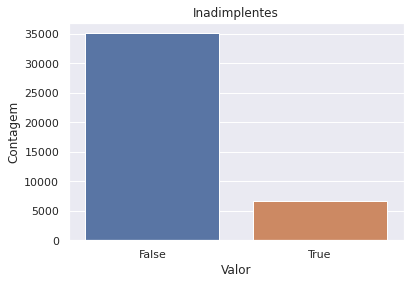

Proporção entre Inadimplentes no Dataset:
False    0.779556
True     0.148022
Name: target_default, dtype: float64


In [ ]:
fig, ax = plt.subplots()
sns.countplot('target_default', data=credito, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")
plt.show()

print("Proporção entre Inadimplentes no Dataset:")
print(credito['target_default'].value_counts() / credito.shape[0])

In [ ]:
credito.nunique().sort_values()

external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts    

### Limpeza

Farei a limpeza de dados com apenas um valor único, com quantidades multo altas de valores únicos, descartar variáveis com mais de 50% dos valores ausentes.

Preencher valores faltantes em 'facebook_profile' com False, considerando que essa pessoa não possui perfil no Facebook.

Deixar apenas a sigla do estado em 'shipping_state'

Descartar linhas onde a variável alvo está ausente e transformar os valores desta variável para 0 e 1.

### Valores Ausentes

Colunas numéricas - Preenchidos com a mediana

Colunas categóricas - Valores substituidos pelos valores presentes na mesma proporção em que estes aparecem na coluna

In [ ]:
# Descartando variáveis
drop = ['external_data_provider_credit_checks_last_2_year', 'ok_since', 'channel',
        'target_fraud','ids', 'last_amount_borrowed', 'profile_phone_number', 
        'reason', 'zip', 'user_agent', 'job_name', 'external_data_provider_first_name',
        'last_borrowed_in_months', 'state', 'shipping_zip_code']

credito_clean = credito.drop(labels=drop, axis=1)
        
#Lidando com valores inf
credito_clean = credito_clean[credito_clean['reported_income'] != np.inf]

#Lidando com valores negativos
credito_clean.loc[credito_clean['external_data_provider_email_seen_before'] < 0,
                 'external_data_provider_email_seen_before'] = np.nan
        
#Transformando a coluna facebook_profile
credito_clean['facebook_profile'].fillna(value=False, inplace=True, axis=0)
credito_clean['facebook_profile'] = credito_clean['facebook_profile'].map({True: 'Sim', False: 'Não'})
        
#Substituindo valores na coluna email
credito_clean.loc[credito_clean['email'] == 'hotmaill.com', 'email'] = 'hotmail.com'
credito_clean.loc[credito_clean['email'] == 'gmaill.com', 'email'] = 'gmail.com'
        
#Deixando apenas a sigla do estado
credito_clean['shipping_state'] = credito_clean['shipping_state'].str[-2:]
        
#Limpando a variável alvo
credito_clean.dropna(subset=['target_default'], inplace=True)
credito_clean['target_default'] = credito_clean['target_default'].map({True: 1, False: 0})
        
credito_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,lat_lon,marketing_channel,reported_income,shipping_state,profile_tags
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,2,0.0,51.0,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,57849.0,MT,"{'tags': ['n19', 'n8']}"
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,1,0.0,17.0,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,4902.0,RS,"{'tags': ['n6', 'n7', 'nim']}"
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,NaN,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,2,NaN,9.0,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,163679.0,RR,"{'tags': ['n0', 'n17', 'nim', 'da']}"
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,Não,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,3,NaN,38.0,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,1086.0,RN,{'tags': ['n4']}
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,60011.29,Sim,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,2,1.0,46.0,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,198618.0,MT,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}"


In [ ]:
def preencher_proporcional(col):
    #Dicionário com valores únicos e porcentagens
    percentages = col.value_counts(normalize=True).to_dict()
    
    #Transformando chaves e valores do dicionário em listas
    percent = [percentages[key] for key in percentages]
    labels = [key for key in percentages]
    
    #Lista para preenchimento de valores nulos na proporção correta
    s = pd.Series(np.random.choice(labels, p=percent, size=col.isnull().sum()))
    col = col.fillna(s)
    
    #Verificando se todos foram preenchidos e preenchendo os que não estiverem
    if len(col.isnull()) > 0:
        col.fillna(value=max(percentages, key=percentages.get), inplace=True, axis=0)
        
    return col

In [ ]:
#Preenchendo valores ausentes
for col in credito_clean.iloc[:,1:].columns.tolist():
    if credito_clean[col].dtypes == 'O':
        credito_clean[col] = preencher_proporcional(credito_clean[col])
    else:
        credito_clean[col].fillna(value=credito_clean[col].median(), inplace=True, axis=0)

In [ ]:
credito_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
credit_limit                                       0
income                                             0
facebook_profile                                   0
real_state                                         0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                         0
n_issues                                           0
application_time_applied                           0
application_time_in_funnel                         0
email                                         

In [ ]:
#Excluindo valores dos minutos e segundos
credito_clean['application_time_applied'] = credito_clean['application_time_applied'].str[:2].astype(int)
credito_clean.loc[credito_clean['application_time_applied'] == 24, 'application_time_applied'] = 0

#Transformando a coluna profile_tags
credito_clean['profile_tags'] = credito_clean['profile_tags'].str.extract('\[(.*)]')
credito_clean['profile_tags'] = credito_clean['profile_tags'].str.replace("''", "").str.replace(',', '')

credito_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,lat_lon,marketing_channel,reported_income,shipping_state,profile_tags
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,7,444,outlook.com,2,0.0,51.0,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,57849.0,MT,'n19' 'n8'
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,2,346,gmail.com,1,0.0,17.0,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,4902.0,RS,'n6' 'n7' 'nim'
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,25206.0,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,0,6,gmail.com,2,1.0,9.0,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,163679.0,RR,'n0' 'n17' 'nim' 'da'
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,Não,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11,406,spgov.com,3,1.0,38.0,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,1086.0,RN,'n4'
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,25206.0,60011.29,Sim,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,13,240,gmail.com,2,1.0,46.0,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,198618.0,MT,'pro+aty' 'n19' 'da' 'b19'


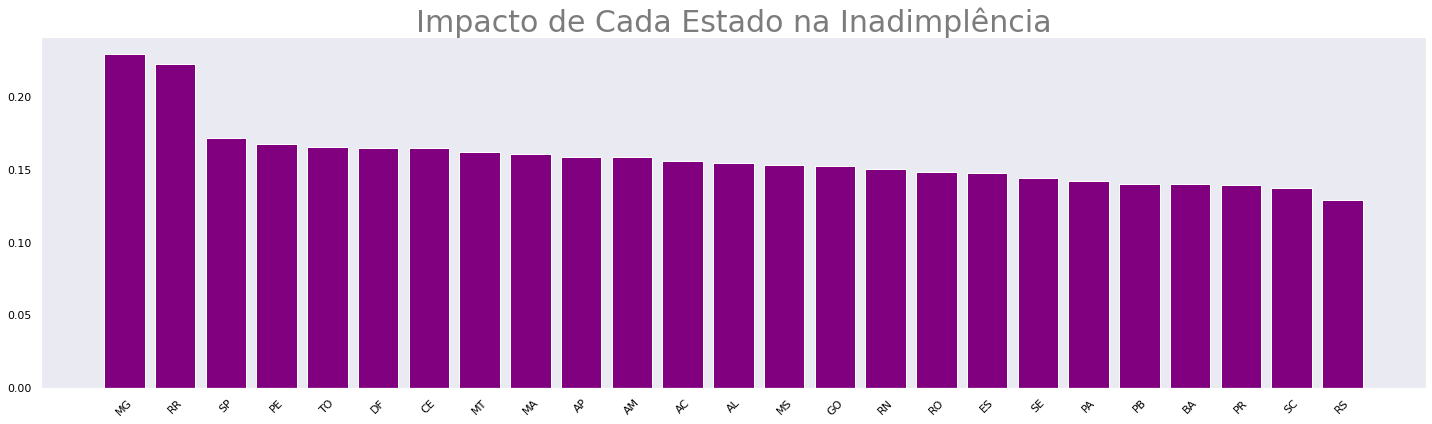

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
grouped = credito_clean.groupby('shipping_state').target_default.mean().sort_values(ascending=False)
ax.bar(grouped.index, grouped, color='purple')
ax.grid(False)
ax.set_xlabel('')
ax.set_xticklabels(grouped.index, rotation=45)
ax.tick_params(colors='black')
ax.set_title('Impacto de Cada Estado na Inadimplência', fontsize = 30, alpha=0.6)

plt.tight_layout()

Dois estados se destacam no número de Inadimplência por estado

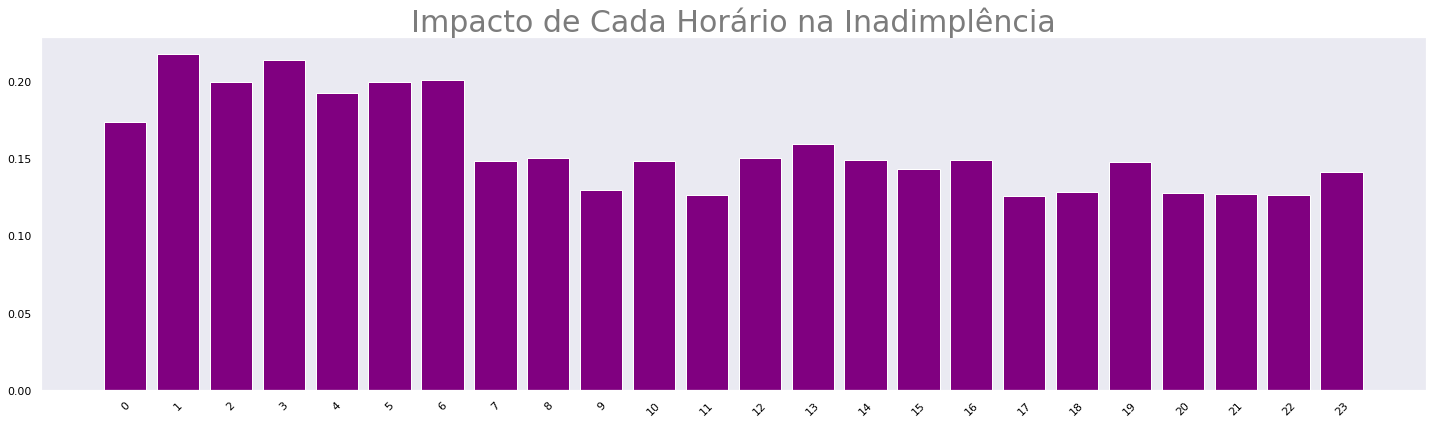

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
grouped = credito_clean.groupby('application_time_applied').target_default.mean().sort_index()
ax.bar(grouped.index, grouped, color='purple')
ax.grid(False)
ax.set_xlabel('')
ax.set_xticklabels(grouped.index, rotation=45)
ax.set_xticks(range(0, 25))
ax.tick_params(colors='black')
ax.set_title('Impacto de Cada Horário na Inadimplência', fontsize = 30, alpha=0.6)

plt.tight_layout()

Compras feitas entre meia-noite e 7 horas são as que possuem maior inadimplência

Por isso irei separar as aplicações feitas de madrugada das outras

In [ ]:
credito_clean['overnight'] = credito_clean['application_time_applied'].apply(lambda x: 1 if x < 6 else 0)

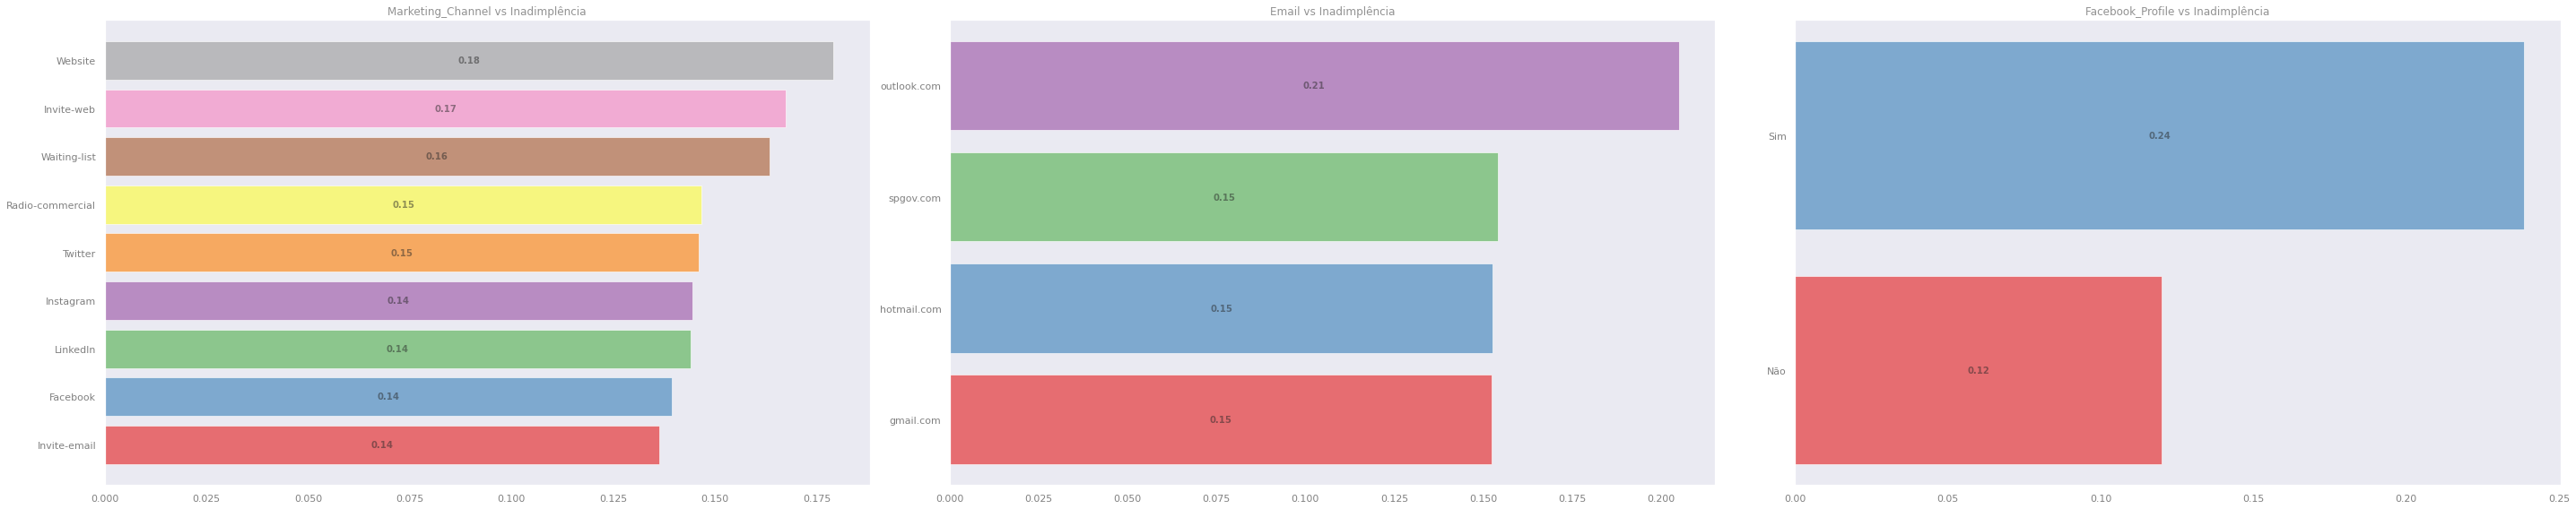

In [ ]:
categorical = ['marketing_channel', 'email', 'facebook_profile']

fig = plt.figure(figsize=(40, 8))

for i in range(len(categorical)):
    to_plot = credito_clean.groupby(categorical[i]).target_default.mean().sort_values()
    ax = fig.add_subplot(1, 3, i+1)
    rects = ax.barh(to_plot.index, to_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.grid(False)
    ax.tick_params(labelleft=True)
    ax.set_title(f'{categorical[i].title()} vs Inadimplência', alpha=0.5)
    ax.tick_params(colors='grey')
    
    for rect in (rects):
        width = rect.get_width()
        ax.text(y=rect.get_y() + rect.get_height() / 2, x=width * 0.5, s=round(width, 2), ha='center', va='center', alpha=0.5, fontweight='bold')

plt.tight_layout()
plt.show()

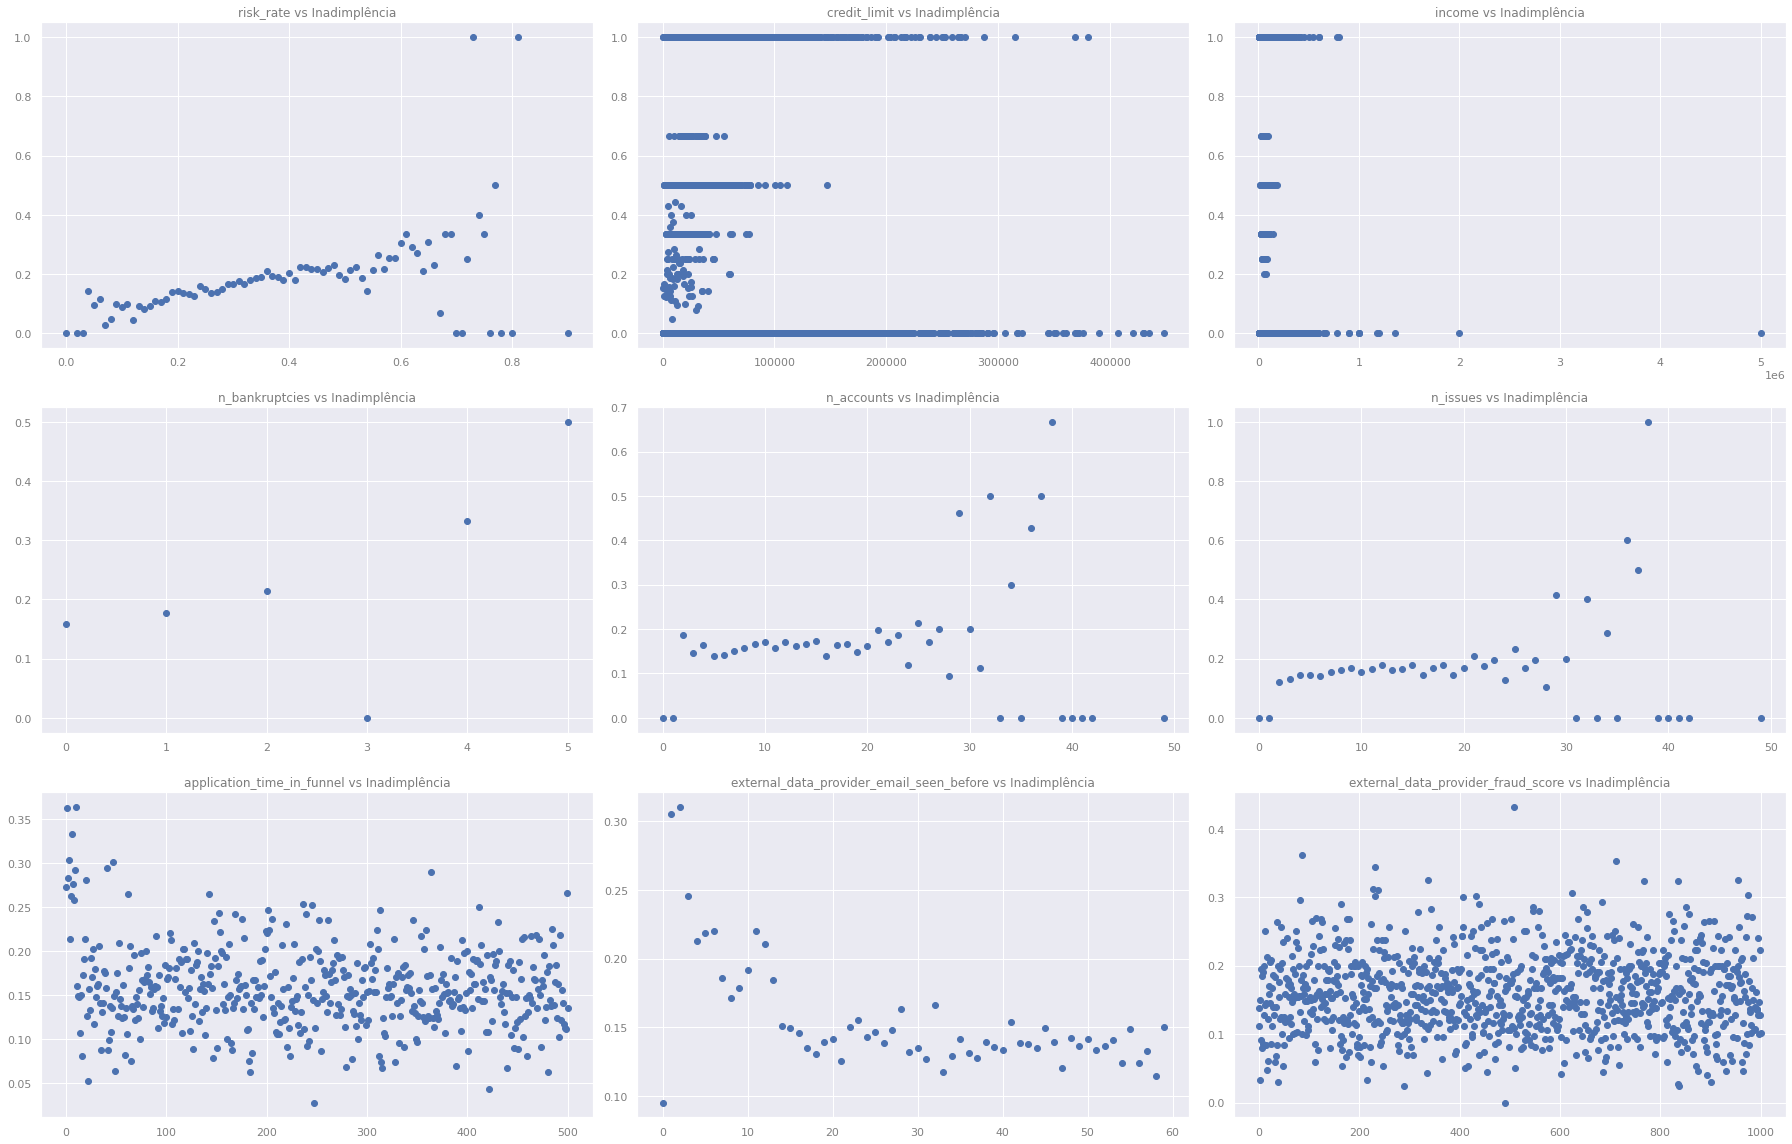

In [ ]:
numeric = ['risk_rate', 'credit_limit', 'income', 'n_bankruptcies', 'n_accounts',
 'n_issues', 'application_time_in_funnel', 'external_data_provider_email_seen_before',
 'external_data_provider_fraud_score']

fig = plt.figure(figsize=(25, 16))
for i in range(len(numeric)):
    num_plot = credito_clean.groupby(numeric[i]).target_default.mean()
    ax = fig.add_subplot(3, 3, i+1)
    ax.scatter(num_plot.index, num_plot)
    ax.set_title(f'{numeric[i]} vs Inadimplência', alpha = 0.6)
    ax.tick_params(colors='grey')
    
plt.tight_layout()
plt.savefig('num.png')
plt.show()

In [ ]:
#Criando colunas latitude e longitude
credito_clean['latitude'] = credito_clean['lat_lon'].str.split(',').str[0].str.replace('(','').astype(float)
credito_clean['longitude'] = credito_clean['lat_lon'].str.split(',').str[1].str.replace(')', '').astype(float)

#Arredondando os valores
credito_clean = credito_clean.round({'latitude': 4, 'longitude': 4})

credito_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,lat_lon,marketing_channel,reported_income,shipping_state,profile_tags,overnight,latitude,longitude
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,7,444,outlook.com,2,0.0,51.0,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,57849.0,MT,'n19' 'n8',0,-29.1515,-51.1386
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,2,346,gmail.com,1,0.0,17.0,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,4902.0,RS,'n6' 'n7' 'nim',1,-19.6877,-47.9415
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,25206.0,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,0,6,gmail.com,2,1.0,9.0,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,163679.0,RR,'n0' 'n17' 'nim' 'da',1,-28.7480,-51.8673
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,Não,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11,406,spgov.com,3,1.0,38.0,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,1086.0,RN,'n4',0,-17.5207,-39.7580
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,25206.0,60011.29,Sim,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,13,240,gmail.com,2,1.0,46.0,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,198618.0,MT,'pro+aty' 'n19' 'da' 'b19',0,-16.5743,-39.9099


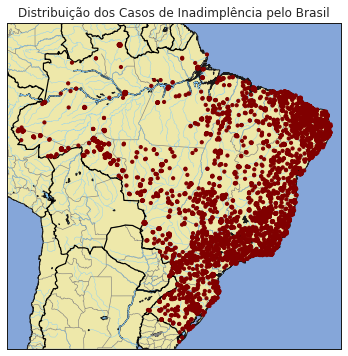

In [ ]:
credito_1 = credito_clean[credito_clean['target_default'] == 1]

plt.figure(figsize=(20, 6))
m = Basemap(projection='cyl', resolution='h', llcrnrlat=-34.5, urcrnrlat=5.57, llcrnrlon=-74.5, urcrnrlon=-33.47)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines()
m.fillcontinents(color='palegoldenrod', lake_color='lightskyblue')
m.drawstates(color='grey', linewidth=.6)
m.drawrivers(color='lightskyblue', linewidth=.4)
m.drawcountries(color='black', linewidth=1.2)

m.scatter(credito_1['longitude'], credito_1['latitude'], s=10, zorder=2, latlon=True, c=credito_1['target_default'], cmap=plt.get_cmap('jet_r'))
plt.title('Distribuição dos Casos de Inadimplência pelo Brasil')
plt.savefig('map.png')
plt.show()

In [ ]:
credito_clean.drop(['latitude', 'longitude', 'lat_lon'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


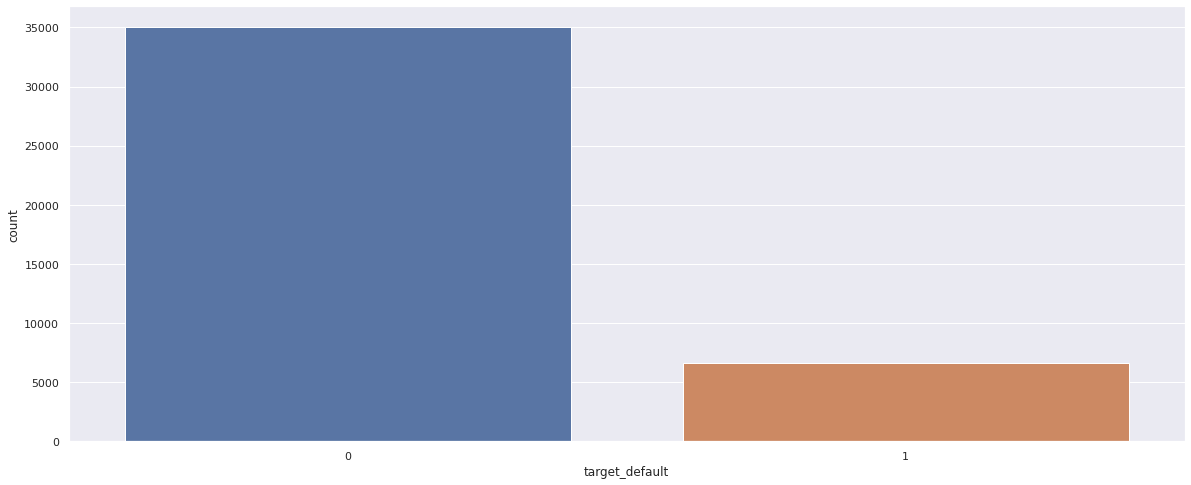

0    35025
1     6650
Name: target_default, dtype: int64

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.countplot(credito_clean['target_default'])
plt.show()

credito_clean['target_default'].value_counts()

In [ ]:
#Transformando cada conjunto de tags de uma lista
credito_clean['profile_tags'] = credito_clean['profile_tags'].str.split()

#Criando uma lista com as tags únicas
tags_unicas = []
for tags in credito_clean['profile_tags']:
    for tag in tags:
        tags_unicas.append(tag)
        
tags_unicas = list(set(tags_unicas))

#Criando colunas a partir das tags únicas
for tag in tags_unicas:
    credito_clean[tag] = credito_clean['profile_tags'].apply(lambda x: 1 if tag in x else 0)

#Descartando a coluna 'profile_tags'
credito_clean.drop('profile_tags', axis=1, inplace=True)

credito_clean.head()

,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,real_state,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,marketing_channel,reported_income,shipping_state,overnight,'n11','n4','n14','n3','n10','b19','n2','n0','n15','dfa','nim','da','n18','a15','n9','aty','c1','pro+aty','n5','n19','n17','n13','n6','n7','n1','n12','c55','n8','n16'
0,0,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,Sim,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,18.0,18.0,7,444,outlook.com,2,0.0,51.0,645,Invite-email,57849.0,MT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,Não,N5/CE7lSkAfB04hVFFwllw==,0.0,0.0,14.0,14.0,2,346,gmail.com,1,0.0,17.0,243,Radio-commercial,4902.0,RS,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,1,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,25206.0,65023.65,Não,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,10.0,10.0,0,6,gmail.com,2,1.0,9.0,65,Waiting-list,163679.0,RR,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,Não,n+xK9CfX0bCn77lClTWviw==,1.0,0.0,19.0,19.0,11,406,spgov.com,3,1.0,38.0,815,Waiting-list,1086.0,RN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,25206.0,60011.29,Sim,n+xK9CfX0bCn77lClTWviw==,0.0,0.0,11.0,10.0,13,240,gmail.com,2,1.0,46.0,320,Invite-email,198618.0,MT,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
cols_encode = ['score_1', 'score_2', 'facebook_profile', 'real_state']

for col in cols_encode:
    encoder = LabelEncoder().fit(credito_clean[col])
    credito_clean[col] = encoder.transform(credito_clean[col])
    
col_dummies = cols_encode + ['application_time_applied', 'email', 'marketing_channel', 'shipping_state']
col_dummies.remove('facebook_profile')

credito_clean = pd.get_dummies(credito_clean, columns=col_dummies)

credito_clean.head()

,target_default,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,facebook_profile,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,overnight,'n11','n4','n14','n3','n10','b19','n2','n0','n15','dfa','nim','da','n18','a15','n9','aty','c1','pro+aty','n5','n19',...,application_time_applied_22,application_time_applied_23,email_gmail.com,email_hotmail.com,email_outlook.com,email_spgov.com,marketing_channel_Facebook,marketing_channel_Instagram,marketing_channel_Invite-email,marketing_channel_Invite-web,marketing_channel_LinkedIn,marketing_channel_Radio-commercial,marketing_channel_Twitter,marketing_channel_Waiting-list,marketing_channel_Website,shipping_state_AC,shipping_state_AL,shipping_state_AM,shipping_state_AP,shipping_state_BA,shipping_state_CE,shipping_state_DF,shipping_state_ES,shipping_state_GO,shipping_state_MA,shipping_state_MG,shipping_state_MS,shipping_state_MT,shipping_state_PA,shipping_state_PB,shipping_state_PE,shipping_state_PR,shipping_state_RN,shipping_state_RO,shipping_state_RR,shipping_state_RS,shipping_state_SC,shipping_state_SE,shipping_state_SP,shipping_state_TO
0,0,350.0,101.800832,0.259555,108.427273,0.40,0.0,65014.12,1,0.0,0.0,18.0,18.0,444,2,0.0,51.0,645,57849.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,370.0,97.062615,0.942655,92.002546,0.24,39726.0,100018.91,0,0.0,0.0,14.0,14.0,346,1,0.0,17.0,243,4902.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,360.0,100.027073,0.351918,112.892453,0.29,25206.0,65023.65,0,0.0,0.0,10.0,10.0,6,2,1.0,9.0,65,163679.0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,510.0,101.599485,0.987673,94.902491,0.32,54591.0,68830.01,0,1.0,0.0,19.0,19.0,406,3,1.0,38.0,815,1086.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,500.0,98.474289,0.532539,118.126207,0.18,25206.0,60011.29,1,0.0,0.0,11.0,10.0,240,2,1.0,46.0,320,198618.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
credito_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41675 entries, 0 to 44999
Columns: 158 entries, target_default to shipping_state_TO
dtypes: float64(14), int64(35), uint8(109)
memory usage: 21.5 MB


1    35025
0    35025
Name: target_default, dtype: int64 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


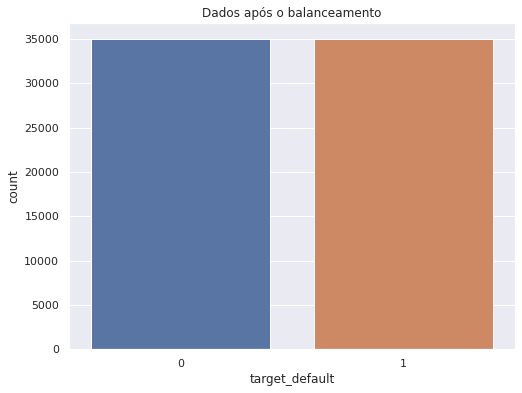

In [ ]:
#Dividindo e padronizando o dataset original
X = credito_clean.drop('target_default', axis=1)
y = credito_clean['target_default']

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_unb = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Criando o dataset balanceado
maioria = credito_clean[credito_clean['target_default'] == 0]
minoria = credito_clean[credito_clean['target_default'] == 1]

minoria_balanceada = resample(minoria, replace=True, n_samples=35025)

credito_balanceado = pd.concat([maioria, minoria_balanceada])

#Dividindo e padronizando o dataset balanceado
X_balanceado = credito_balanceado.drop('target_default', axis=1)
y_balanceado = credito_balanceado['target_default']

X_train_balanceado, X_test_balanceado, y_train_balanceado, y_test_balanceado = train_test_split(X_balanceado, y_balanceado)

scaler_balanceado = StandardScaler()
scaler_balanceado.fit(X_train_balanceado)
X_train_balanceado = scaler_balanceado.transform(X_train_balanceado)
X_test_balanceado = scaler_balanceado.transform(X_test_balanceado)

#Verificando o balanceamento
print(credito_balanceado['target_default'].value_counts(), '\n')

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(credito_balanceado['target_default'])
ax.set_title('Dados após o balanceamento')
plt.show()

### Machine Learning

Usarei quatro algoritmos para treinar modelos:
- Regressão Logística;
- Árvores de Decisão;
- Random Forest;
- XGBoost.

Testarei o desempenho desses tanto com dados balanceados como desbalanceados por técnica de validação cruzada seguindo as seguintes métricas:
- Acurácia;
- Precisão;
- Recall;
- Área sob a curva ROC.

In [ ]:
# Criando os modelos utilizando validação cruzada
reglog_balanceado = cross_validate(LogisticRegression(solver='liblinear'), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
reglog = cross_validate(LogisticRegression(solver='liblinear'), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

trees_balanceado = cross_validate(DecisionTreeClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
trees = cross_validate(DecisionTreeClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

forest_balanceado = cross_validate(RandomForestClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
forest = cross_validate(RandomForestClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

xgb_balanceado = cross_validate(XGBClassifier(), X_train_balanceado, y_train_balanceado, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
xgb = cross_validate(XGBClassifier(), X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])

#Gerando um DataFrame com os resultados de cada modelo
summary = pd.DataFrame({
    'labels': ['accuracy', 'precision', 'recall', 'roc_auc'],
    'reglog_balanceado': [reglog_balanceado['test_accuracy'].mean(), reglog_balanceado['test_precision'].mean(), reglog_balanceado['test_recall'].mean(), reglog_balanceado['test_roc_auc'].mean()],
    'reglog': [reglog['test_accuracy'].mean(), reglog['test_precision'].mean(), reglog['test_recall'].mean(), reglog['test_roc_auc'].mean()],
    'trees_balanceado': [trees_balanceado['test_accuracy'].mean(), trees_balanceado['test_precision'].mean(), trees_balanceado['test_recall'].mean(), trees_balanceado['test_roc_auc'].mean()],
    'trees': [trees['test_accuracy'].mean(), trees['test_precision'].mean(), trees['test_recall'].mean(), trees['test_roc_auc'].mean()],
    'forest_balanceado':[forest_balanceado['test_accuracy'].mean(), forest_balanceado['test_precision'].mean(), forest_balanceado['test_recall'].mean(), forest_balanceado['test_roc_auc'].mean()],
    'forest': [forest['test_accuracy'].mean(), forest['test_precision'].mean(), forest['test_recall'].mean(), forest['test_roc_auc'].mean()],
    'xgb_balanceado': [xgb_balanceado['test_accuracy'].mean(), xgb_balanceado['test_precision'].mean(), xgb_balanceado['test_recall'].mean(), xgb_balanceado['test_roc_auc'].mean()],
    'xgb': [xgb['test_accuracy'].mean(), xgb['test_precision'].mean(), xgb['test_recall'].mean(), xgb['test_roc_auc'].mean()]
}).set_index('labels')
summary.index.name=None
summary = summary.transpose()
summary.style.applymap(lambda x: 'background-color: lightgreen' if x >= 0.75 else '')



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

,accuracy,precision,recall,roc_auc
reglog_balanceado,0.667111,0.666713,0.667797,0.727951
reglog,0.841342,0.000000,0.000000,0.500150
trees_balanceado,0.877039,0.817970,0.969838,0.877076
trees,0.747057,0.233109,0.259729,0.549342
forest_balanceado,0.957021,0.950018,0.964773,0.986874
forest,0.842622,0.651557,0.018150,0.701588
xgb_balanceado,0.677541,0.675609,0.682611,0.744078
xgb,0.844414,0.642539,0.044567,0.723688


Entre as métricas escolhidas para análise, a que teve melhor desempenho foi Random Forest com os dados balanceados, sendo a escolhida para o projeto.

### Tunning de Hiperparâmetros

Utilizarei a técnica Grid Search para ajuste do modelo e escolher o melhor valor para os seguintes parâmetros:
- criterion;
- n_estimators;
- max_depth;
- min_samples_split;
- min_samples_leaf.

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

forest = RandomForestClassifier()

param_grid = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9866322121346677 para {'criterion': 'gini'}


In [ ]:
forest = RandomForestClassifier(criterion='gini')

param_grid = {'n_estimators': range(50, 500, 50)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9866661527520135 para {'n_estimators': 200}


In [ ]:
forest = RandomForestClassifier(criterion='gini', n_estimators=400)

param_grid = {'max_depth': range(1, 10)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor Resultado: {result.best_score_} para {result.best_params_}')

Melhor Resultado: 0.7677206451508033 para {'max_depth': 9}


In [ ]:
forest = RandomForestClassifier(criterion='gini', n_estimators=400)

param_grid = {'min_samples_split': range(2, 10, 2)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.9879883214296141 para {'min_samples_split': 2}


In [ ]:
forest = RandomForestClassifier(criterion='gini', n_estimators=400, min_samples_split=2)

param_grid = {'min_samples_leaf': range(1, 6, 2)}

search = GridSearchCV(forest, param_grid, scoring='roc_auc', cv=kfold)
result = search.fit(X_train_balanceado, y_train_balanceado)

print(f'Melhor resultado: {result.best_score_} para {result.best_params_}')

Melhor resultado: 0.987541449555064 para {'min_samples_leaf': 1}


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8746
           1       0.97      0.98      0.98      8767

    accuracy                           0.98     17513
   macro avg       0.98      0.98      0.98     17513
weighted avg       0.98      0.98      0.98     17513

ROC_AUC Score: 0.9773256837436168 



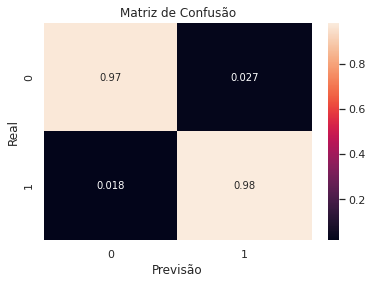

In [ ]:
modelo = RandomForestClassifier(criterion='gini', n_estimators=400, min_samples_split=2, min_samples_leaf=1)
modelo.fit(X_train_balanceado, y_train_balanceado)

y_pred = modelo.predict(X_test_balanceado)

print(classification_report(y_test_balanceado, y_pred))
print(f'ROC_AUC Score: {roc_auc_score(y_test_balanceado, y_pred)}', '\n')

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test_balanceado, y_pred, normalize='true'), annot=True, ax=ax)
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Real')
ax.set_xlabel('Previsão')
plt.show()

### Conclusão
Neste projeto, trabalhamos com um problema de identificação de risco de crédito com objetivo de construir um modelo de machine learning capaz de identificar possíveis inadimplentes.

Como resultado, além de alguns insights relevantes sobre o impacto de algumas características na variável alvo, foi construído um modelo preditivo que demonstrou acurácia de 98%, sendo considerado um resultado satisfatório e, portanto, cumprindo o objetivo inicialmente proposto.